In [1]:
# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import camb
import sys
sys.path.append('./hmcode/')
import hmcode
import math

In [2]:
# Cosmology
Omega_c = 0.25
Omega_b = 0.05
Omega_k = 0.0
h = 0.7
ns = 0.96
sigma_8 = 0.8
w0 = -1.
wa = 0.
m_nu = 0.
norm_sigma8 = True
As = 2e-9

# CAMB
kmax_CAMB = 200.

# Wavenumbers [h/Mpc]
kmin, kmax = 1e-1, 1e2
nk = 128
k = np.logspace(np.log10(kmin), np.log10(kmax), nk)

# Redshifts
zs = [4., 3., 2., 1., 0.5, 0.]
zs = np.array(zs)

# Halo masses [Msun/h] (for halo model only)
#Mmin, Mmax = 1e0, 1e18
#nM = 256
#M = np.logspace(np.log10(Mmin), np.log10(Mmax), nM)

In [3]:
# Sets cosmological parameters in camb to calculate the linear power spectrum
pars = camb.CAMBparams(WantCls=False)
wb, wc = Omega_b*h**2, Omega_c*h**2

# This function sets standard and helium set using BBN consistency
pars.set_cosmology(ombh2=wb, omch2=wc, H0=100.*h, mnu=m_nu, omk=Omega_k)
pars.set_dark_energy(w=w0, wa=wa, dark_energy_model='ppf')
pars.InitPower.set_params(As=As, ns=ns, r=0.)
pars.set_matter_power(redshifts=zs, kmax=kmax_CAMB) # Setup the linear matter power spectrum
Omega_m = pars.omegam # Extract the matter density

# Scale 'As' to be correct for the desired 'sigma_8' value if necessary
if norm_sigma8:
    results = camb.get_results(pars)
    sigma_8_init = results.get_sigma8_0()
    print('Running CAMB')
    print('Initial sigma_8:', sigma_8_init)
    print('Desired sigma_8:', sigma_8)
    scaling = (sigma_8/sigma_8_init)**2
    As *= scaling
    pars.InitPower.set_params(As=As, ns=ns, r=0.)

# Run
results = camb.get_results(pars)

Running CAMB
Initial sigma_8: 0.805141810731159
Desired sigma_8: 0.8


In [6]:
# DMO c-M relation, no HMF suppresison
Pk_DMO = hmcode.power(k, zs, results, cM='new', cMsim='DMO', hmfsup=False, biassup=False, 
                        a1=1, a2=1, a_node=1, tweaks=False, T_AGN=None)

In [19]:
Pk_cM_hmf_bias = hmcode.power(k, zs, results, cM='new', cMsim='TNG', hmfsup=True, biassup=True, 
                                a1=1, a2=1, a_node=1, tweaks=False, T_AGN=None)

In [20]:
Pk_cM_hmf      = hmcode.power(k, zs, results, cM='new', cMsim='TNG', hmfsup=True, biassup=False, 
                                a1=1, a2=1, a_node=1, tweaks=False, T_AGN=None)

/home/wbc/code/HMcode-python/hmcode/hmcode.py:356: RuntimeWarning: invalid value encountered in log
  f4 = np.log(1.+c)-c/(1.+c)
/home/wbc/code/HMcode-python/hmcode/pyhalomodel/pyhalomodel/pyhalomodel.py:468: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  A = 1.-integrate.quad(lambda nu: self._mass_function_nu(nu) * self._linear_bias_nu(nu), nu[0], np.inf)[0]


In [12]:
# Get the new HMcode spectrum
Pk_cM   = hmcode.power(k, zs, results, cM='new', cMsim='TNG', hmfsup=False, biassup=False, 
                        a1=1, a2=1, a_node=1, tweaks=False, T_AGN=None)
Pk_hmf  = hmcode.power(k, zs, results, cM='new', cMsim='DMO', hmfsup=True,  biassup=False, 
                        a1=1, a2=1, a_node=1, tweaks=False, T_AGN=None)
Pk_bias = hmcode.power(k, zs, results, cM='new', cMsim='DMO', hmfsup=False, biassup=True, 
                        a1=1, a2=1, a_node=1, tweaks=False, T_AGN=None)

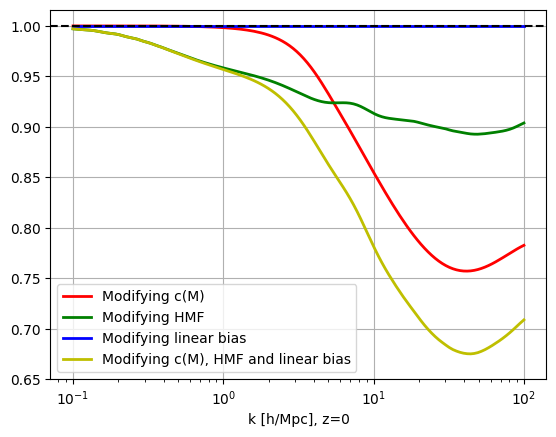

In [37]:
plt.semilogx(k, Pk_cM[-1]/Pk_DMO[-1], c='r', linewidth=2, label='Modifying c(M)')
plt.semilogx(k, Pk_hmf[-1]/Pk_DMO[-1], c='g', linewidth=2, label='Modifying HMF')
plt.semilogx(k, Pk_bias[-1]/Pk_DMO[-1], c='b', linewidth=2, label='Modifying linear bias')
plt.semilogx(k, Pk_cM_hmf[-1]/Pk_DMO[-1], c='y', linewidth=2, label='Modifying c(M), HMF and linear bias')

plt.grid()
plt.xlabel('k [h/Mpc], z=0')
plt.axhline(y=1, c='k', linestyle='--')
plt.ylim(0.65,)
plt.legend()

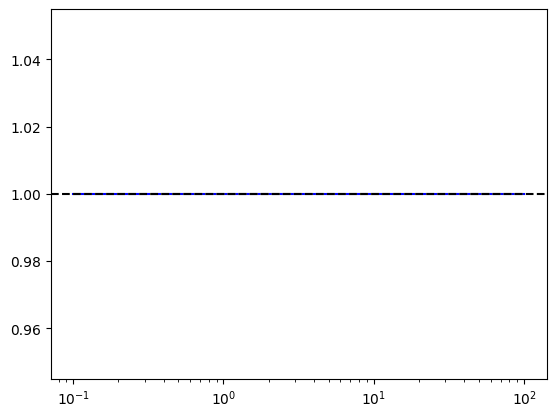

In [24]:
plt.semilogx(k, Pk_bias[-1]/Pk_DMO[-1], '-', c='b', label='bias Modified')
plt.semilogx(k, Pk_cM_hmf_bias[-1]/Pk_cM_hmf[-1], '--', c='y', label='c(M), HMF and bias Modified')
plt.axhline(y=1, c='k', linestyle='--')

In [ ]:
plt.semilogx(k, Pk_hmf_1[-1]/Pk_HMcode[-1], c='k', label='c(M) and HMF Modified v.s. c(M) Modified')
plt.xlabel('k [h/Mpc], z=0')
plt.axhline(y=1, c='k', linestyle='--')
plt.legend()

In [ ]:
plt.semilogx(k, Pk_HMcode[-1]/Pk_HMcode_1[-1], label='z=0')
plt.semilogx(k, Pk_hmf_1[-1]/Pk_HMcode_1[-1], label='z=0', c='y')
plt.semilogx(k, Pk_hmf[-1]/Pk_HMcode_1[-1], label='z=0', c='r')
plt.semilogx(k, Pk_hmf[-1]/Pk_hmf_1[-1], label='z=0', c='g')

In [ ]:
Pk_hmf_m1 = hmcode.power(k, zs, results, SN1=1, AGN1=1, SN2=1, AGN2=1, hmfsup=True, a1=0.8, a2=0.8, a_node=1, sim='TNG', cMrelation='new', tweaks=True)

In [ ]:
pk_hmf_m2 = hmcode.power(k, zs, results, SN1=1, AGN1=1, SN2=1, AGN2=1, hmfsup=True, a1=0.9, a2=0.9, a_node=1, sim='TNG', cMrelation='new', tweaks=True)

In [ ]:
Pk_hmf_norm = hmcode.power(k, zs, results, SN1=1, AGN1=1, SN2=1, AGN2=1, hmfsup=True, a1=1, a2=1, a_node=1, sim='TNG', cMrelation='new', tweaks=True)

In [ ]:
pk_hmf_p1 = hmcode.power(k, zs, results, SN1=1, AGN1=1, SN2=1, AGN2=1, hmfsup=True, a1=1.1, a2=1.1, a_node=1, sim='TNG', cMrelation='new', tweaks=True)

In [ ]:
pk_hmf_p2 = hmcode.power(k, zs, results, SN1=1, AGN1=1, SN2=1, AGN2=1, hmfsup=True, a1=1.2, a2=1.2, a_node=1, sim='TNG', cMrelation='new', tweaks=True)

In [ ]:
pk_hmf_node_m = hmcode.power(k, zs, results, SN1=1, AGN1=1, SN2=1, AGN2=1, hmfsup=True, a1=1, a2=1, a_node=0.7, sim='TNG', cMrelation='new', tweaks=True)

In [ ]:
pk_hmf_node_p = hmcode.power(k, zs, results, SN1=1, AGN1=1, SN2=1, AGN2=1, hmfsup=True, a1=1, a2=1, a_node=1.3, sim='TNG', cMrelation='new', tweaks=True)

In [ ]:
plt.semilogx(k, Pk_hmf_m1[-1]/Pk_HMcode_1[-1], label='a1,a2,a_node=(0.8,0.8,1)')
plt.semilogx(k, pk_hmf_m2[-1]/Pk_HMcode_1[-1], label='a1,a2,a_node=(0.9,0.9,1)')
plt.semilogx(k, Pk_hmf_norm[-1]/Pk_HMcode_1[-1], label='a1,a2,a_node=(1,1,1)',c='k')
plt.semilogx(k, pk_hmf_p1[-1]/Pk_HMcode_1[-1], label='a1,a2,a_node=(1.1,1.1,1)')
plt.semilogx(k, pk_hmf_p2[-1]/Pk_HMcode_1[-1], label='a1,a2,a_node=(1.2,1.2,1)')
plt.semilogx(k, pk_hmf_node_m[-1]/Pk_HMcode_1[-1], label='a1,a2,a_node=(1,1,0.9)',c='k',linestyle='--')
plt.semilogx(k, pk_hmf_node_p[-1]/Pk_HMcode_1[-1], label='a1,a2,a_node=(1,1,1.1)',c='k',linestyle=':')
plt.axhline(y=1, c='k', linestyle='-')
plt.legend()

In [ ]:
X = k.reshape(-1, 1)
y = (Pk_hmf_norm[-1]/Pk_HMcode_1[-1]).reshape(-1, 1)